# **3D visualization model of vertebral column from patient's CT data**

In [1]:
#Need to install pydicom for reading images from dicom files
!pip install pydicom

     |████████████████████████████████| 1.9MB 16.5MB/s 


Importing all necessary packages

In [3]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce

# for reading dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# # ipywidgets for some interactive plots
# from ipywidgets.widgets import * 
# import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

Loading the files with patients' CT data from the Google Drive directory

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading all DICOM images

In [6]:
# This function raeds all DICOM images from the given directory,
# sorts the slices by their location and adjust their thickness

def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
      slice_thickness = np.abs(slices[0].SliceLocation - 
                      slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


# This function creates pixel numpy arrays from the given scan images

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert pixels to Hounsfield units (HU) - a quantitative scale for 
    # describing radiodensity, used in CT scans
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

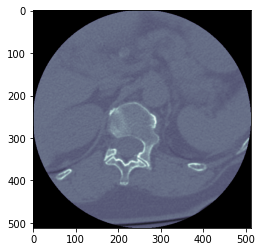

In [30]:
# set path and load files 
path = "drive/My Drive/3D_Imaging/CTdata/series-000001/"
out_path = "drive/My Drive/3D_Imaging/CTdata_numpy/"
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
id = 0
np.save(out_path + "fullimages_%d.npy" % (id), patient_pixels)
# display one of the images
plt.imshow(patient_pixels[0], cmap=plt.cm.bone)

The following histogram helps to infer which pixels correspond to air, and which - to tissue, if we compare it with the known values of Hounsfield units (HU) for different substances. The histogram shows that there is a lot of air (HU = -1000) and water (HU = 0), some soft tissue as muscles (HU = +10 to +40) and liver (HU = +40 to +60), plenty of fat (-100 to -50) and a bit of bone (+700 to +3000). Thus, there is a need for preprocessing in order to obtain the vertebral column, because it seems to be represented by only a small fraction of the voxels.

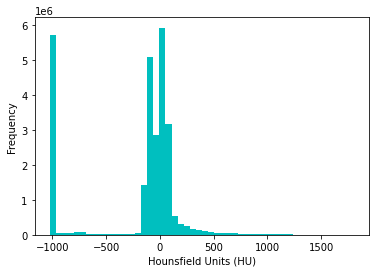

In [31]:
file_used=out_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

Plotting a 3D image of vertebral column using merching cubes without image preprocessing

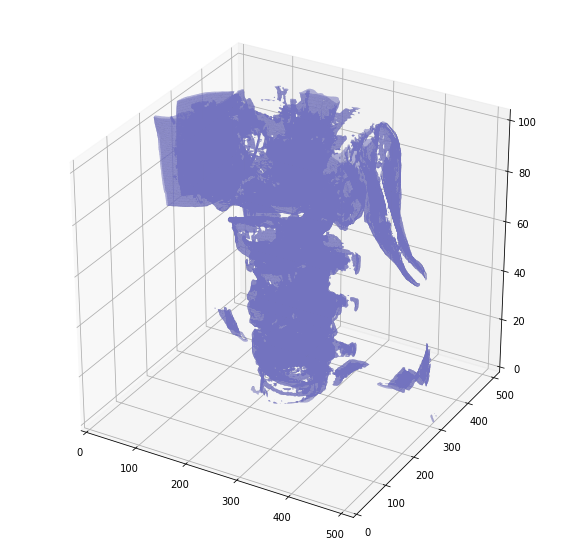

In [8]:
def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    # face_color = [1, 1, 0.9]

    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
# run visualization 
plot_3d(patient_pixels)

**Image preprocessing**

Preprocessing to improve the quality of a 3D model

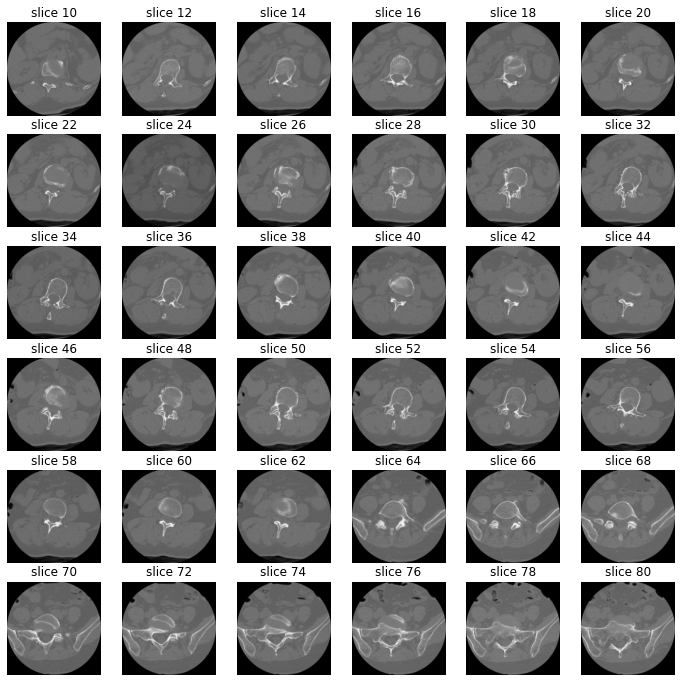

In [33]:
# Displaying every two images in a stack

id = 0
imgs_to_process = np.load(out_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=2):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [26]:
print("Slice Thickness: %f" % patient_dicom[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient_dicom[0].PixelSpacing[0], patient_dicom[0].PixelSpacing[1]))

Slice Thickness: 8.750000
Pixel Spacing (row, col): (0.351562, 0.351562) 


The above output means that we have 8.75 mm thick slices, and each voxel represents 0.35 mm.

In order to display the CT in 3D isometric form, and to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.

In [45]:
id = 0
imgs_to_process = np.load(out_path+'fullimages_{}.npy'.format(id))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient_dicom, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (102, 512, 512)
Shape after resampling	 (892, 180, 180)


In [55]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [0.7, 0.7, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    # ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

The above function takes a threshold argument which we can use to plot certain substances, such as all tissue or only the bones. 400 is a good threshold for showing the bones only.

Transposing surface
Calculating surface
Drawing


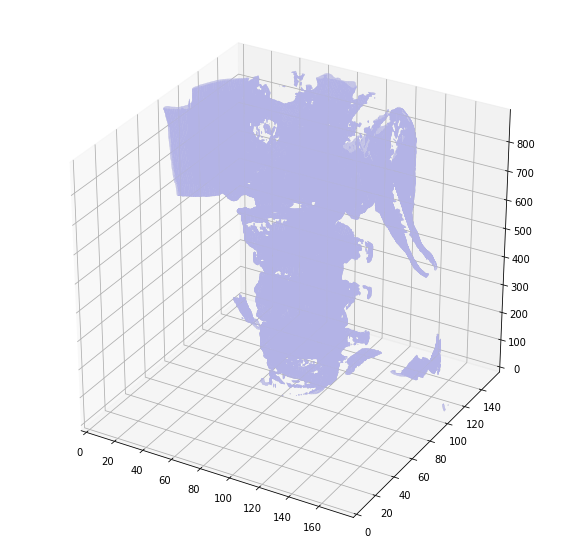

In [57]:
v, f = make_mesh(imgs_after_resamp, 400)
plt_3d(v, f)

Thus, the vertebral column was obtained from the CT data of the patient. The resultant model has some missing parts either due to missing data or it needs better image preprocessing to visualize proper parts. Also, as was mentioned earlier, HU analysis revealed a little amount of bones, therefore preprocessing with the emphasis on extracting the bones structures might be useful. Further procedures such as segmentation and normalization should be applied in order to use the images for Machine Learning models.